# Predicting vibrational frequencies from the external chemical environment

This notebook is part of Lab 2 in the DoE course, hosted by the Computational Materials Chemistry group at Uppsala University.

Here, we explore a data set of infrared (IR) frequencies for various water species in bulk and on an oxide surface, using t-tests and ANOVA, and principal component analysis (PCA). The data also includes several descriptors that potentially could be used for model building. Ideally, we want to be able to extract structural information from the observed IR frequency of a sample. 

Contents:  
[Import libraries](#imports)   
[Load data](#loading)  
[Inspect data](#inspect)  
[Explore the data](#explore)   
[Statistical analysis](#stats)     
[Principal component analysis (PCA)](#pca)  
[Model building through regression](#regression)

#### Import libraries <a id='imports'></a>
Import all the libraries needed for this lab

In [93]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import f_oneway

### Load data <a id='loading'></a>
Use `glob.glob()` to read a list of all the .csv files in the `Data` folder to the `files` variable.

In [94]:
# Get CSV files list from a folder
files = glob.glob('./Data/*.csv')

files

['./Data\\bulk_data_1.csv',
 './Data\\bulk_data_2.csv',
 './Data\\Suface_data.csv']

### Inspect data <a id='inspect'></a>
Read each file into a pandas dataframe and inspect.

In [95]:
df_bulk_1 = pd.read_csv(files[0])
df_bulk_1 = df_bulk_1.loc[:, ~df_bulk_1.columns.str.contains('^Unnamed')]

print('The size of this dataframe is:')
print(df_bulk_1.shape)

df_bulk_1.head()

The size of this dataframe is:
(100, 9)


,Frequency,acceptor_type,Type,EFddec,EFfc,rHO,rOO,tOHO,sOH
0,2835.330710,H2O,water,NaN,0.110286,1.700949,2.700508,173.394783,0.829656
1,3183.645055,O2-,water,NaN,0.053310,1.803902,2.768058,164.461785,0.854042
2,3035.028611,O2-,water,NaN,0.056955,1.770575,2.750204,167.845087,0.844688
3,2897.650546,H2O,water,NaN,0.111810,1.711288,2.708017,173.473205,0.833939
4,3294.220653,O2-,water,NaN,0.001428,1.966437,2.945567,173.304077,0.893110


In [96]:
df_bulk_2 = pd.read_csv(files[1])
df_bulk_2 = df_bulk_2.loc[:, ~df_bulk_2.columns.str.contains('^Unnamed')]

print('The size of this dataframe is:')
print(df_bulk_2.shape)

df_bulk_2.head()

The size of this dataframe is:
(26, 7)


,Frequency,acceptor_type,Type,rHO,rOO,tOHO,sOH
0,NaN,OH-,hydroxide,2.658786,3.462083,140.056868,0.965521
1,NaN,OH-,hydroxide,2.658785,3.462083,140.056865,0.965521
2,NaN,OH-,hydroxide,2.658785,3.462083,140.056865,0.965521
3,3491.972,OH-,hydroxide,2.658786,3.462083,140.056870,0.965521
4,3548.512,OH-,hydroxide,3.004040,3.624301,122.855193,0.966211


In [97]:
df_surface = pd.read_csv(files[2])
df_surface = df_surface.loc[:, ~df_surface.columns.str.contains('^Unnamed')]
df_surface.rename(columns = {'OH_bond_order':'sOH'}, inplace = True)

# The sOHQM is the same as OH_bond_order/sOH, so we can drop that column
df_surface.drop(['sOHQM'], axis=1, inplace=True)

print('The size of this dataframe is:')
print(df_surface.shape)

df_surface.head()

The size of this dataframe is:
(217, 9)


,Frequency,EFddec,EFfc,acceptor_type,Type,rHO,rOO,tOHO,sOH
0,3577.868,0.000151,0.000402,NaN,water,3.000000,3.500000,100.000000,0.8974
1,3577.868,0.000152,0.000405,NaN,water,3.000000,3.500000,100.000000,0.8970
2,3511.409,0.015010,0.032563,H2O,water,3.000000,3.500000,100.000000,0.8292
3,2952.498,0.053806,0.102202,O2-,water,1.790404,2.653346,142.511457,0.7401
4,3514.452,0.039665,0.066010,OH-,hydroxide,3.000000,3.500000,100.000000,0.8793


### Combine all data <a id='combine'></a>
Add a descriptor "bulk" or "surface" to each row of data, and concaternate the three dataframes into one.

In [98]:
# Label the environment in each data set
df_bulk_1.insert(0,'environment', 'bulk')
df_bulk_2.insert(0,'environment', 'bulk')
df_surface.insert(0,'environment', 'surface')

In [99]:
# Concatenate all DataFrames into one
df_all = pd.concat([df_bulk_1, df_bulk_2, df_surface], ignore_index=True)
df_all.drop_duplicates(keep = 'last', inplace=True)
df_all.rename(columns = {'Type':'species'}, inplace = True)

df_all

,environment,Frequency,acceptor_type,species,EFddec,EFfc,rHO,rOO,tOHO,sOH
0,bulk,2835.330710,H2O,water,NaN,0.110286,1.700949,2.700508,173.394783,0.829656
1,bulk,3183.645055,O2-,water,NaN,0.053310,1.803902,2.768058,164.461785,0.854042
2,bulk,3035.028611,O2-,water,NaN,0.056955,1.770575,2.750204,167.845087,0.844688
3,bulk,2897.650546,H2O,water,NaN,0.111810,1.711288,2.708017,173.473205,0.833939
4,bulk,3294.220653,O2-,water,NaN,0.001428,1.966437,2.945567,173.304077,0.893110
...,...,...,...,...,...,...,...,...,...,...
338,surface,2816.551000,OH-,hydroxide,0.109617,0.163932,1.639930,2.539967,147.456023,0.714200
339,surface,2528.199000,OH-,hydroxide,0.110814,0.174560,1.648772,2.603764,155.716061,0.734100
340,surface,3584.097000,NaN,hydroxide,0.032979,0.060920,3.000000,3.500000,100.000000,0.945400
341,surface,3047.550000,OH-,water,0.041758,0.062331,1.917147,2.859469,156.956777,0.784200


In [100]:
# There is one row of data with frequency > 180 000. This is most likely wrong. Remove the row.
df_all.drop(df_all[df_all['Frequency'] >= 5000].index , inplace=True)

# Also drop all rows where there is no value for the frequency 
df_all = df_all.dropna(subset=['Frequency'])

In [101]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 342
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   environment    294 non-null    object 
 1   Frequency      294 non-null    float64
 2   acceptor_type  263 non-null    object 
 3   species        294 non-null    object 
 4   EFddec         217 non-null    float64
 5   EFfc           287 non-null    float64
 6   rHO            294 non-null    float64
 7   rOO            294 non-null    float64
 8   tOHO           294 non-null    float64
 9   sOH            294 non-null    float64
dtypes: float64(7), object(3)
memory usage: 25.3+ KB


In [102]:
# Check unique values of target varaible
df_all['acceptor_type'].value_counts()

OH-    99
H2O    92
O2-    72
Name: acceptor_type, dtype: int64

In [103]:
# Check unique values of target varaible
df_all['species'].value_counts()

water        195
hydroxide     99
Name: species, dtype: int64

## Exploratory data analysis  <a id='explore'></a>
Let's first make a pair plot with `seaborn` to explore dependencies in our data. 

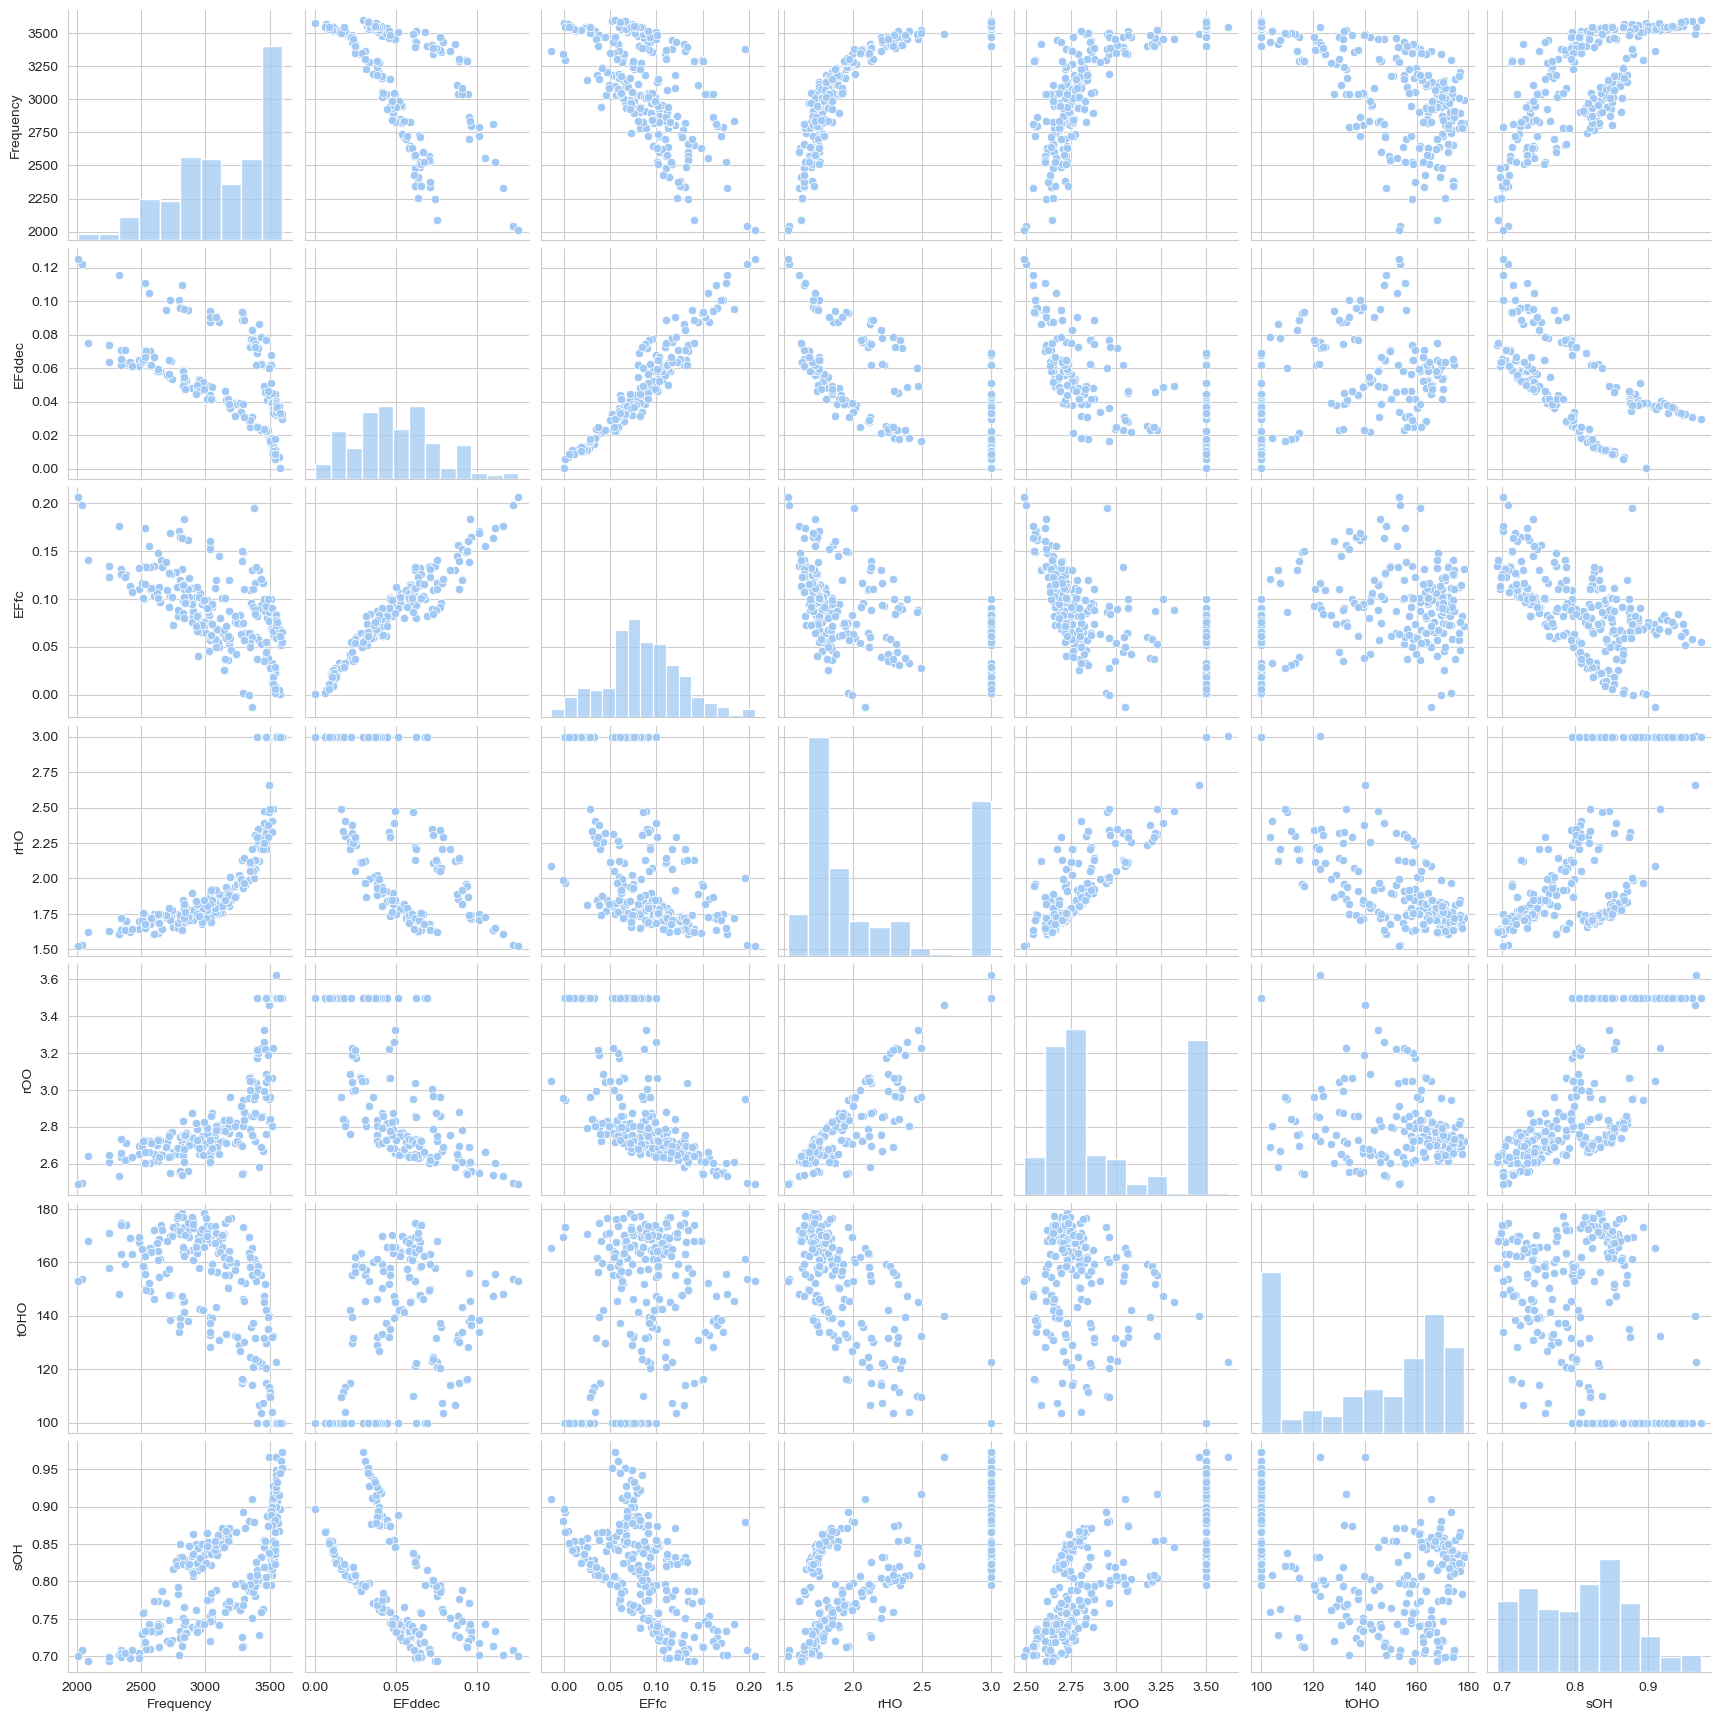

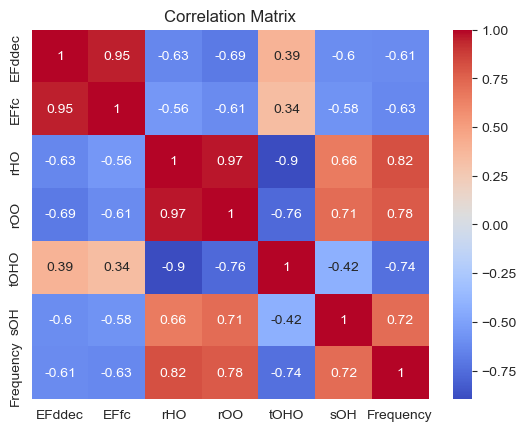

In [104]:
# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Make the pair plot
sns.pairplot(df_all)
plt.show()

# Correlation matrix between descriptors and frequency
corr_matrix = df_all[descriptors + ['Frequency']].corr()
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Some observations we can make are:

- There are two different groups which have different dependencies of EFddec and sOH on the frequency.
- Frequency has some sort of logarithmic or inverse exponential dependency on rHO. Similar for rOO, but less clear.

In the correlation matrix, we can see that some descriptors have moderate to strong correlations with the frequency. For example, `rHO` (0.82), `rOO` (0.78), and `sOH` (0.72) have positive correlations, indicating that as these descriptors increase, the frequency tends to increase as well. On the other hand, `EFddec` (-0.61) and `EFfc` (-0.63) have negative correlations, suggesting that as these descriptors increase, the frequency tends to decrease.  We also saw this in the pair plots, but here we get a numerical value for an easier comparison.

Let's look at how the frequency depends on different descriptors for the bulk and surface data separately.

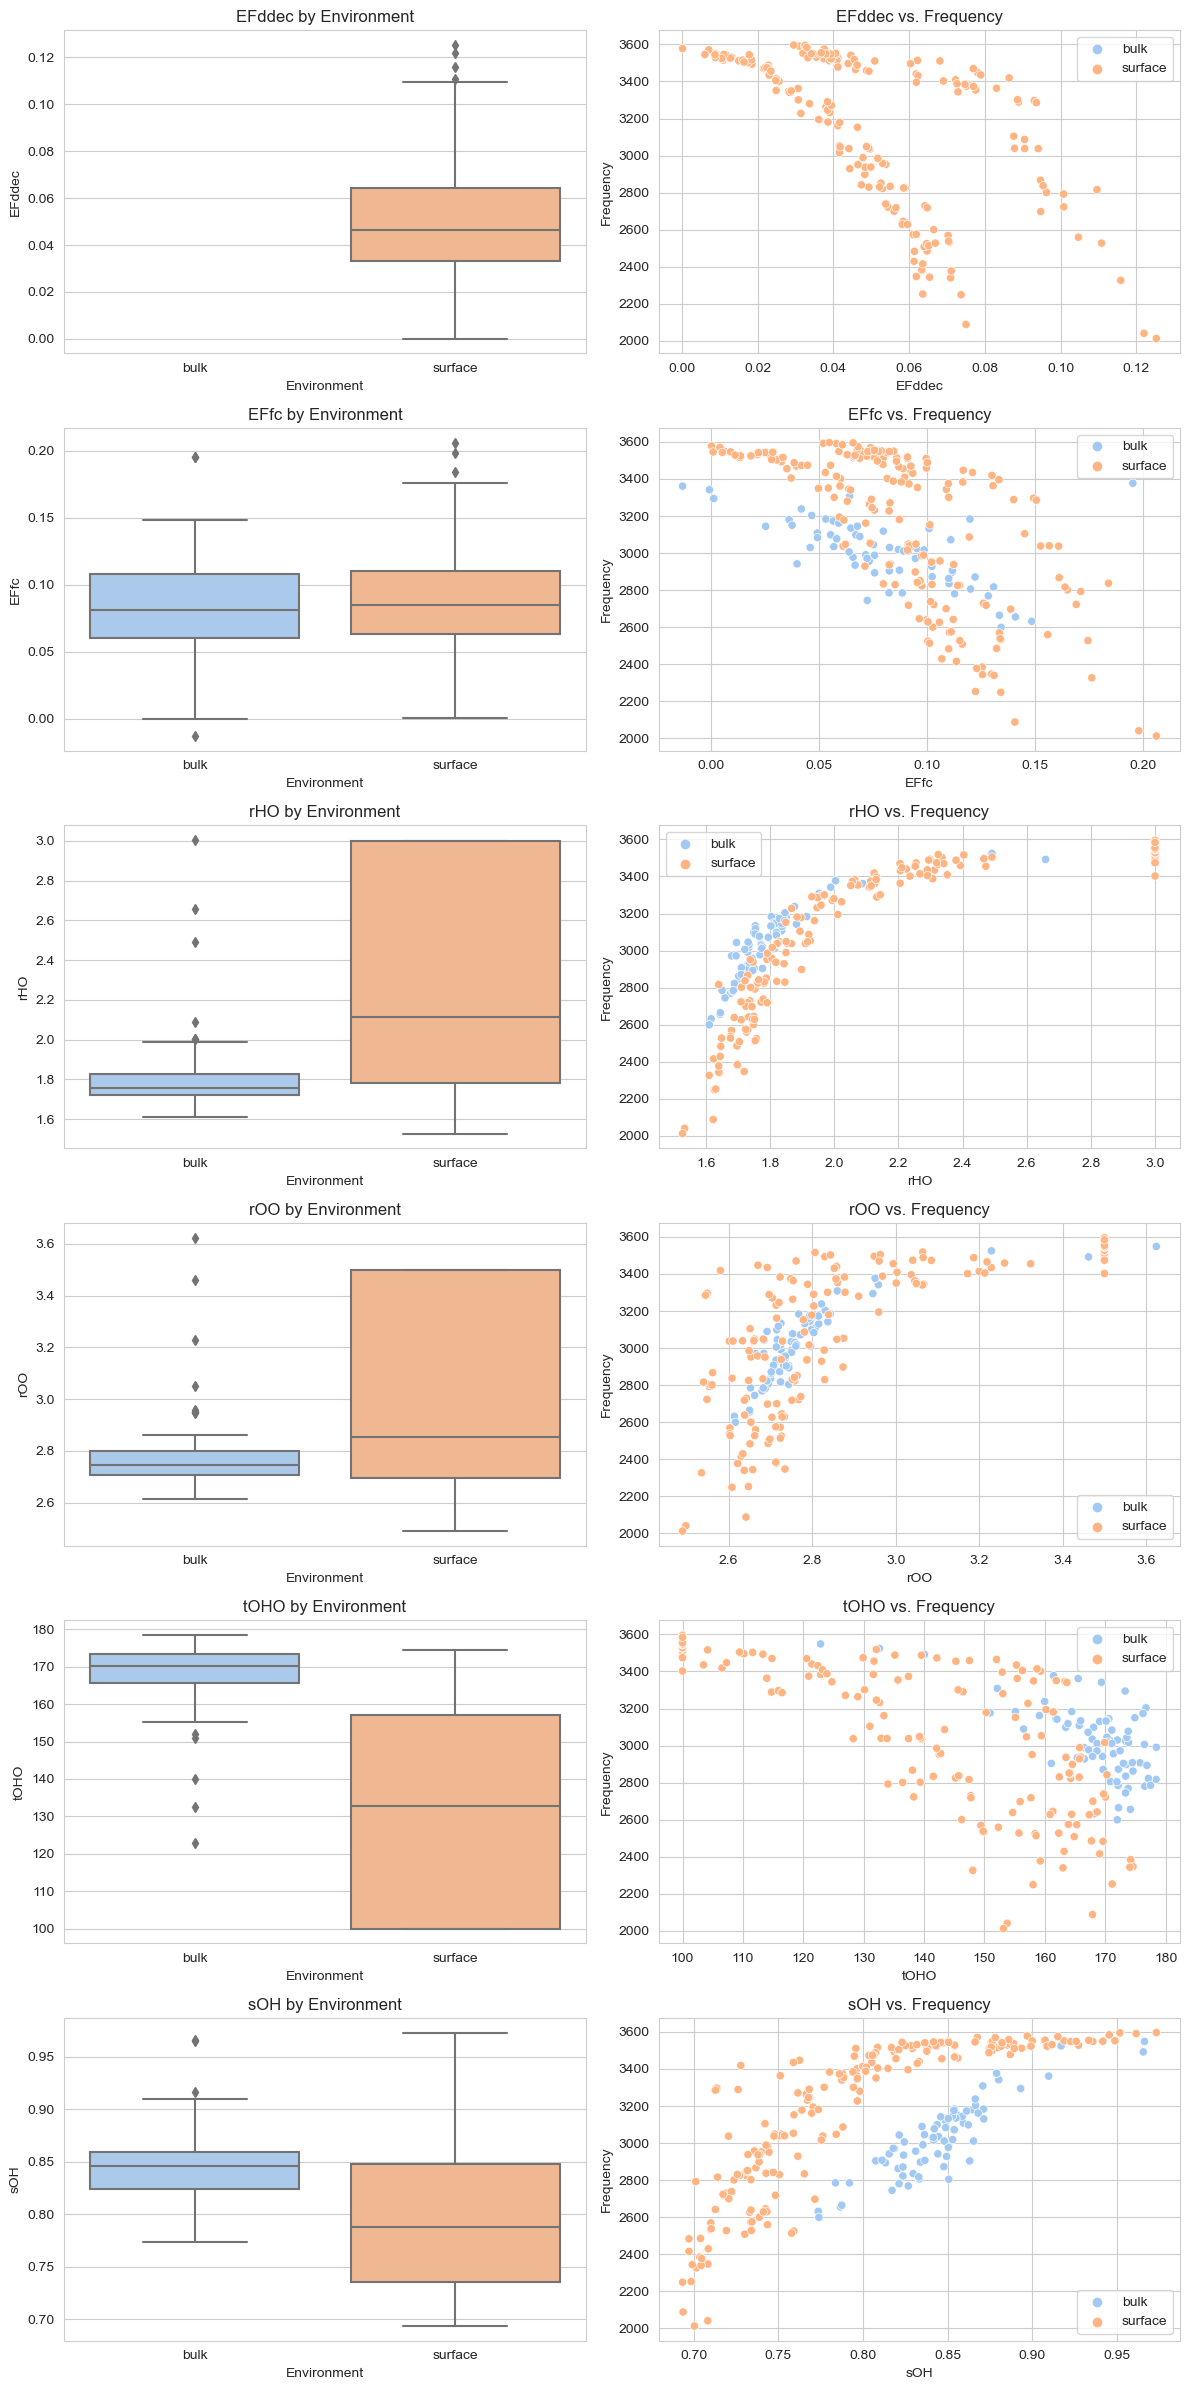

In [105]:
# Visualize the relationships between descriptors and frequency for bulk and surface data separately

# Create a 6x2 grid of subplots
fig, axes = plt.subplots(6, 2, figsize=(12, 24))

descriptors = ['EFddec', 'EFfc', 'rHO', 'rOO', 'tOHO', 'sOH']

# Iterate over the descriptors and plot the box plots and scatter plots
for i, descriptor in enumerate(descriptors):
    # Calculate the row and column indices for the subplot
    row = i % 6
    col = i // 6

    # Plot the box plot on the corresponding subplot
    ax_box = axes[row, col]
    sns.boxplot(data=df_all, x='environment', y=descriptor, ax=ax_box)
    ax_box.set_xlabel('Environment')
    ax_box.set_ylabel(descriptor)
    ax_box.set_title(f'{descriptor} by Environment')

    # Plot the scatter plot on the corresponding subplot
    ax_scatter = axes[row, col+1]
    sns.scatterplot(data=df_all, x=descriptor, y='Frequency', hue='environment', ax=ax_scatter)
    ax_scatter.set_xlabel(descriptor)
    ax_scatter.set_ylabel('Frequency')
    ax_scatter.set_title(f'{descriptor} vs. Frequency')
    ax_scatter.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In the above figures, we see:

- That the two groups in the EFddec - Frequency plot both belong to the surface group.
- There is a difference in the frequency-descriptor dependencies between the surface and bulk data for rHO, rOO, and sOH. Hence, these are the two groups we previously observed in the sOH - frequency plot.

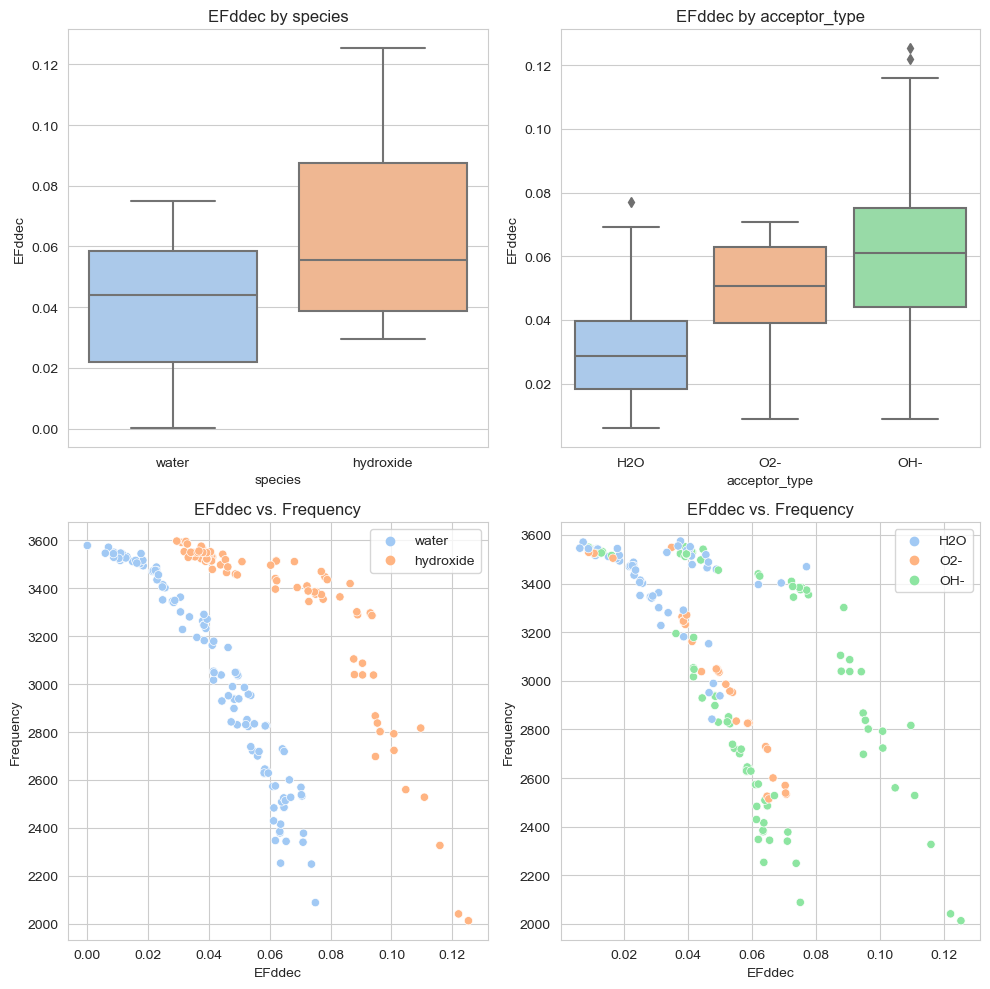

In [106]:
# Visualize the relationships between EFddec and frequency for the different categories

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

categories = ['species', 'acceptor_type']

# Iterate over the categories and plot the box plots and scatter plots
for i, category in enumerate(categories):
    # Calculate the row and column indices for the subplot
    row = i // 2
    col = i % 2

    # Plot the box plot on the corresponding subplot
    ax_box = axes[row, col]
    sns.boxplot(data=df_all, x=category, y='EFddec', ax=ax_box)
    ax_box.set_xlabel(category)
    ax_box.set_ylabel('EFddec')
    ax_box.set_title(f'EFddec by {category}')

    # Plot the scatter plot on the corresponding subplot
    ax_scatter = axes[row+1, col]
    sns.scatterplot(data=df_all, x='EFddec', y='Frequency', hue=category, ax=ax_scatter)
    ax_scatter.set_xlabel('EFddec')
    ax_scatter.set_ylabel('Frequency')
    ax_scatter.set_title('EFddec vs. Frequency')
    ax_scatter.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

The two groups are the water and hydroxide "donor" species!

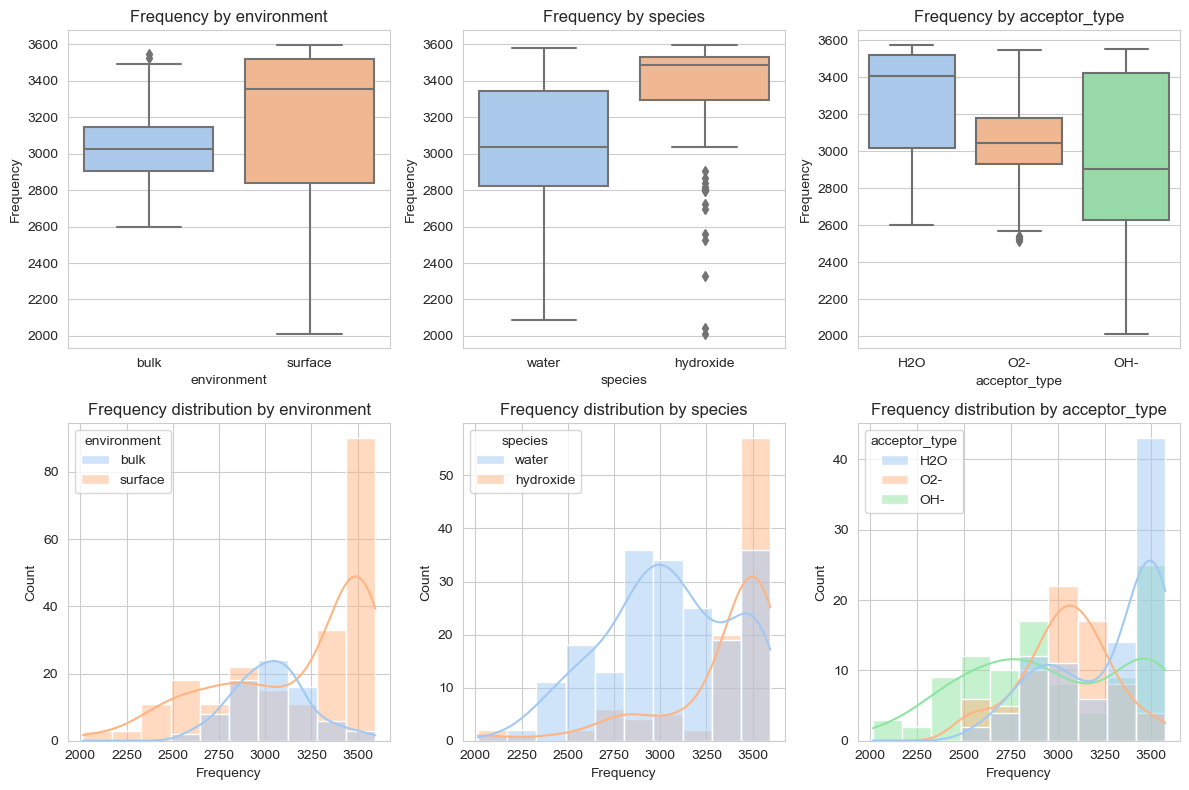

In [107]:
# Visualize the relationships between EFddec and frequency for the different categories

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

categories = ['environment', 'species', 'acceptor_type']

# Iterate over the categories and plot the box plots and frequency distributions
for i, category in enumerate(categories):
    # Calculate the row and column indices for the subplot
    row = i // 3
    col = i % 3

    # Plot the box plot on the corresponding subplot
    ax_box = axes[row, col]
    sns.boxplot(data=df_all, x=category, y='Frequency', ax=ax_box)
    ax_box.set_xlabel(category)
    ax_box.set_ylabel('Frequency')
    ax_box.set_title(f'Frequency by {category}')

    # Plot the frequency distribution on the corresponding subplot
    ax_hist = axes[row+1, col]
    sns.histplot(data=df_all, x='Frequency', kde=True, hue=category, ax=ax_hist)
    ax_hist.set_xlabel('Frequency')
    ax_hist.set_title(f'Frequency distribution by {category}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


There seems to be some differences in frequency within the different categories. The question one could now ask, is whether the differences are statistical. Let's do some statistical analysis on it!

## Statistical analysis  <a id='stats'></a>

### Difference between main categories
Let's first compare the surface data vs the bulk.

In [108]:
bulk_values = df_all[df_all['environment'] == 'bulk']['Frequency'].dropna()
surface_values = df_all[df_all['environment'] == 'surface']['Frequency'].dropna()

t_statistic, p_value = ttest_ind(bulk_values, surface_values)

print(f"Bulk - Mean: {bulk_values.mean():.3f}, Variance: {bulk_values.var():.3f}, Population Size: {len(bulk_values)}")
print(f"Surface    - Mean: {surface_values.mean():.3f}, Variance: {surface_values.var():.3f}, Population Size: {len(surface_values)}")
print(f"p-value: {p_value}")
    
# Compare the p-value with the significance level
alpha = 0.5
if p_value < alpha:
    print("Reject the null hypothesis. The distributions are significantly different.\n")
elif np.isnan(p_value):
    print("nan detected.\n")
else:
    print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

Bulk - Mean: 3031.065, Variance: 40262.525, Population Size: 77
Surface    - Mean: 3172.121, Variance: 167244.409, Population Size: 217
p-value: 0.003979632581415228
Reject the null hypothesis. The distributions are significantly different.



The data sets are statistically different from each other! However, this raises the question of whether it's different because of physical differences or because the number of entries of the other two categories are different between the data sets. In other words, the frequency for the surface data may just be shifted because it includes a lot more data with hydroxide as a species compared to bulk.

Let's see if there is a statistical difference between the groups of species and acceptor types.

In [109]:
water_values = df_all[df_all['species'] == 'water']['Frequency'].dropna()
hydroxide_values = df_all[df_all['species'] == 'hydroxide']['Frequency'].dropna()

t_statistic, p_value = ttest_ind(water_values, hydroxide_values)

print(f"Water - Mean: {water_values.mean():.3f}, Variance: {water_values.var():.3f}, Population Size: {len(water_values)}")
print(f"Hydroxide    - Mean: {hydroxide_values.mean():.3f}, Variance: {hydroxide_values.var():.3f}, Population Size: {len(hydroxide_values)}")
print(f"p-value: {p_value}")
    
# Compare the p-value with the significance level
alpha = 0.5
if p_value < alpha:
    print("Reject the null hypothesis. The distributions are significantly different.\n")
elif np.isnan(p_value):
    print("nan detected.\n")
else:
    print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

Water - Mean: 3037.799, Variance: 121797.896, Population Size: 195
Hydroxide    - Mean: 3326.984, Variance: 114239.308, Population Size: 99
p-value: 6.435864665816351e-11
Reject the null hypothesis. The distributions are significantly different.



In [110]:
def unique_no_nan(x):
    return x.dropna().unique()

acceptor_types = unique_no_nan(df_all['acceptor_type'])

groups = []

for acceptor_type in acceptor_types:
    group_values = df_all[(df_all['acceptor_type'] == acceptor_type)]['Frequency'].dropna()
    groups.append(group_values)

f_statistic, p_value = f_oneway(*groups)

print(f"ANOVA")

for acceptor_type, group in zip(acceptor_types, groups):
    group_size = len(group)
    group_mean = group.mean()
    group_var = group.var()
    print(f"{acceptor_type} - Mean: {group_mean:.3f}, Variance: {group_var:.3f}, Population Size: {group_size}")
print(f"p-value: {p_value}")
    
# Compare the p-value with the significance level
alpha = 0.5
if p_value < alpha:
    print("Reject the null hypothesis. The distributions are significantly different.\n")
elif np.isnan(p_value):
    print("nan detected.\n")
else:
    print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

ANOVA
H2O - Mean: 3270.802, Variance: 84234.891, Population Size: 92
O2- - Mean: 3042.975, Variance: 58425.101, Population Size: 72
OH- - Mean: 2964.577, Variance: 194380.284, Population Size: 99
p-value: 9.18728258506917e-09
Reject the null hypothesis. The distributions are significantly different.



There is! In both cases we see a statistical difference. Hence, both acceptor type and species will influence the frequency. Keep in mind though that we still may be seeing differences because of uneven data sets.

### Combined influence of species and acceptor type
For fun, let's see if there are differences between the groups of combined species and acceptor types, e.g., water_OH- and hydroxide_H2O.

For that, we first need to create a list of all different combinations. Then we need to re-format our data such that we only select the frequencies that belong to that combination. Lastly, we can perform ANOVA to see if they differ. We expect them to since both categories showed differences before.

In [111]:
from itertools import product

# Get unique species and acceptor_type values
species_values = df_all['species'].unique()
acceptor_type_values = df_all['acceptor_type'].unique()

# Create a list of all possible combinations
combinations = [f"{species}_{acceptor_type}" for species, acceptor_type in product(species_values, acceptor_type_values) if pd.notnull(species) and pd.notnull(acceptor_type)]

# Prepare the arguments for ANOVA test
arguments = []
for combination in combinations:
    subset = df_all[(df_all['species'] + '_' + df_all['acceptor_type']) == combination]
    frequencies = subset['Frequency']
    arguments.append(frequencies)

In [112]:
# Perform ANOVA test
F_test, p_value = f_oneway(*arguments)

# Print ANOVA test results
print("ANOVA Test:")
print("F-value:", F_test)
print("p-value:", p_value)

# Compare the p-value with the significance level
alpha = 0.5
if p_value < alpha:
    print("Reject the null hypothesis. The distributions are significantly different.\n")
elif np.isnan(p_value):
    print("nan detected.\n")
else:
    print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

ANOVA Test:
F-value: 21.172810061647997
p-value: 1.0115614446336913e-17
Reject the null hypothesis. The distributions are significantly different.



The results show what we expected. We can now have a look at how many entries we have of each combination and put them in a dataframe to ease further analysis.

In [113]:
# Iterate over the combinations and arguments and print the count
for i, (combination, argument) in enumerate(zip(combinations, arguments)):
    count = len(argument)
    print(f"{combination}: {count}")

water_H2O: 72
water_O2-: 71
water_OH-: 49
hydroxide_H2O: 20
hydroxide_O2-: 1
hydroxide_OH-: 50


In [114]:
# Create an empty DataFrame
df_grouped = pd.DataFrame()

# Determine the maximum length of the columns
max_length = max(len(frequencies) for frequencies in arguments)

# Iterate over the combinations and populate the DataFrame
for combination, frequencies in zip(combinations, arguments):
    column_name = combination
    # Pad the frequencies with NaN values to match the maximum length
    padded_frequencies = np.pad(frequencies, (0, max_length - len(frequencies)), constant_values=np.nan)
    df_grouped[column_name] = padded_frequencies

df_grouped

,water_H2O,water_O2-,water_OH-,hydroxide_H2O,hydroxide_O2-,hydroxide_OH-
0,2835.330710,3183.645055,2823.271,3555.905,3548.823,3491.972
1,2897.650546,3035.028611,3518.565,3513.575,NaN,3548.512
2,2927.987093,3294.220653,2379.458,3520.896,NaN,3524.669
3,2872.817176,3361.462213,2898.283,3521.127,NaN,3176.496
4,2806.240383,2941.701495,2385.175,3523.071,NaN,3142.427
...,...,...,...,...,...,...
67,3455.607000,2834.243000,NaN,NaN,NaN,NaN
68,3351.039000,3528.553000,NaN,NaN,NaN,NaN
69,3404.907000,2525.274000,NaN,NaN,NaN,NaN
70,3348.877000,2514.172000,NaN,NaN,NaN,NaN


Now that we have a dataframe, we can easily plot the frequency distributions for each group. To make it different from before, let's do it in a violin plot instead of a box plot.

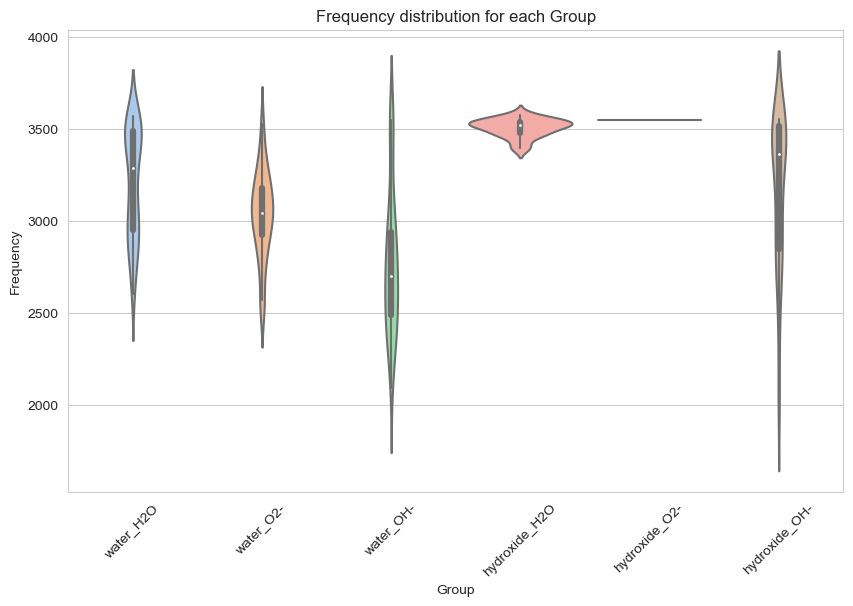

In [115]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_grouped)
plt.xlabel('Group')
plt.ylabel('Frequency')
plt.title('Frequency distribution for each Group')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

We can now make pairwise t-tests between the groups to see which pairs that are statistically different from each other. We will both make it "by hand" and through a Tukey test.

In [116]:
# Get the column names (group names)
group_names = df_grouped.columns

# Perform pairwise t-tests
for i in range(len(group_names)):
    for j in range(i + 1, len(group_names)):
        group1 = group_names[i]
        group2 = group_names[j]
        data1 = df_grouped[group1].dropna()
        data2 = df_grouped[group2].dropna()
        t_statistic, p_value = ttest_ind(data1, data2)
        
        print(f"{group1} vs {group2}:")
        print("t-statistic:", t_statistic)
        print("p-value:", p_value)
        
        # Compare the p-value with the significance level
        alpha = 0.5
        if p_value < alpha:
            print("Reject the null hypothesis. The distributions are significantly different.\n")
        elif np.isnan(p_value):
            print("nan detected.\n")
        else:
            print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

water_H2O vs water_O2-:
t-statistic: 3.788977646716106
p-value: 0.00022336152491042238
Reject the null hypothesis. The distributions are significantly different.

water_H2O vs water_OH-:
t-statistic: 7.203946236947558
p-value: 5.7748590175420866e-11
Reject the null hypothesis. The distributions are significantly different.

water_H2O vs hydroxide_H2O:
t-statistic: -4.51793922077498
p-value: 1.890579504036055e-05
Reject the null hypothesis. The distributions are significantly different.

water_H2O vs hydroxide_O2-:
t-statistic: nan
p-value: nan
nan detected.

water_H2O vs hydroxide_OH-:
t-statistic: 0.6640321315642598
p-value: 0.5079436040025428
Fail to reject the null hypothesis. The distributions are NOT significantly different.

water_O2- vs water_OH-:
t-statistic: 4.867576333434765
p-value: 3.53502851482022e-06
Reject the null hypothesis. The distributions are significantly different.

water_O2- vs hydroxide_H2O:
t-statistic: -8.839231685908562
p-value: 8.082795121260887e-14
Reject 

C:\Users\veren607\AppData\Local\Temp\ipykernel_19412\1385189735.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(data1, data2)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


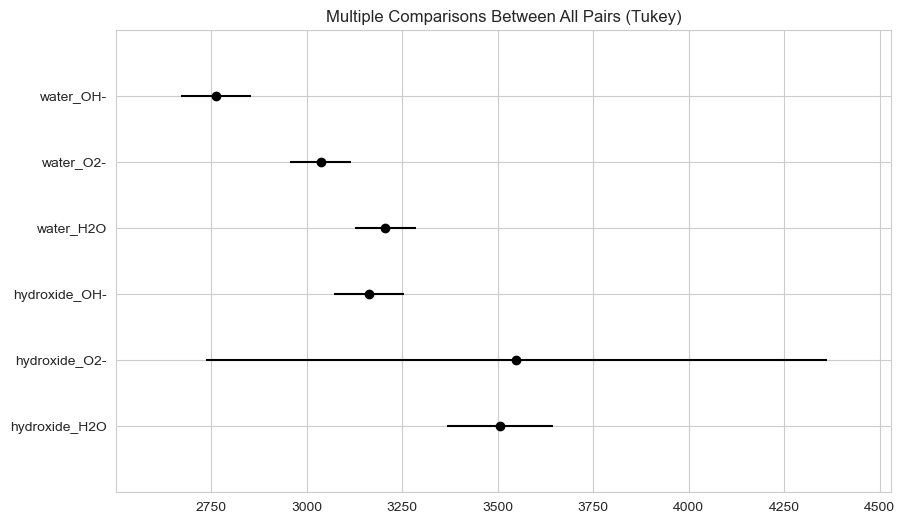

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1        group2     meandiff p-adj    lower      upper   reject
------------------------------------------------------------------------
hydroxide_H2O hydroxide_O2-   42.5394    1.0  -878.8378  963.9166  False
hydroxide_H2O hydroxide_OH- -343.1284 0.0007  -581.0269 -105.2298   True
hydroxide_H2O     water_H2O  -300.893 0.0025    -528.17   -73.616   True
hydroxide_H2O     water_O2- -470.4332    0.0  -698.0578 -242.8085   True
hydroxide_H2O     water_OH- -744.3379    0.0   -982.929 -505.7467   True
hydroxide_O2- hydroxide_OH- -385.6678 0.8271  -1293.787  522.4515  False
hydroxide_O2-     water_H2O -343.4324 0.8854 -1248.8272  561.9624  False
hydroxide_O2-     water_O2- -512.9726 0.5817 -1418.4547  392.5095  False
hydroxide_O2-     water_OH- -786.8773 0.1316 -1695.1782  121.4236  False
hydroxide_OH-     water_H2O   42.2354 0.9777  -123.2926  207.7634  False
hydroxide_OH-     water_O2- -127.3048 0.2404  -293.

In [117]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Create an empty DataFrame to store the data
data = pd.DataFrame(columns=['data', 'group'])

# Iterate over the group names and populate the DataFrame
for group_name in group_names:
    frequencies = df_grouped[group_name].dropna()
    data = pd.concat([data, pd.DataFrame({'data': frequencies, 'group': len(frequencies) * [group_name]})], ignore_index=True)

# Perform Tukey's test
tukey = pairwise_tukeyhsd(endog=data['data'], groups=data['group'], alpha=0.05)

# Plot group confidence intervals
tukey.plot_simultaneous()
plt.show()

# Print test summary
print(tukey.summary())

We get the same result in both methods, except for the combo hydroxide_OH- and water_O2-.

In most cases, they are all statistically different. Hence, we can say that the combination of species and acceptor type is heavily influencing the frequency.

### Surface vs bulk <a id='surface_bulk'></a>
Now that we know the influence of the specie_acceptor combination, we can again test the difference between surface and bulk frequency. But this time, we will do it for each specie_acceptor group separetely.

In [118]:
# Create dataframes for bulk and surface data separately
bulk_data = df_all[df_all['environment'] == 'bulk']
surface_data = df_all[df_all['environment'] == 'surface']

# Prepare the arguments for ANOVA test
arguments_bulk = []
for combination in combinations:
    subset = bulk_data[(bulk_data['species'] + '_' + bulk_data['acceptor_type']) == combination]
    frequencies = subset['Frequency']
    arguments_bulk.append(frequencies)
    
arguments_surface = []
for combination in combinations:
    subset = surface_data[(surface_data['species'] + '_' + surface_data['acceptor_type']) == combination]
    frequencies = subset['Frequency']
    arguments_surface.append(frequencies)

In [119]:
# Bulk data
# Iterate over the combinations and arguments and print the count
for i, (combination, argument) in enumerate(zip(combinations, arguments_bulk)):
    count = len(argument)
    print(f"{combination}: {count}")

water_H2O: 28
water_O2-: 42
water_OH-: 0
hydroxide_H2O: 0
hydroxide_O2-: 0
hydroxide_OH-: 7


In [120]:
# Surface data
# Iterate over the combinations and arguments and print the count
for i, (combination, argument) in enumerate(zip(combinations, arguments_surface)):
    count = len(argument)
    print(f"{combination}: {count}")

water_H2O: 44
water_O2-: 29
water_OH-: 49
hydroxide_H2O: 20
hydroxide_O2-: 1
hydroxide_OH-: 43


In [121]:
# Perform pairwise t-tests between bulk and surface data for each combination
for combination, bulk_argument, surface_argument in zip(combinations, arguments_bulk, arguments_surface):
    t_statistic, p_value = ttest_ind(bulk_argument, surface_argument, nan_policy='omit')
    print(f"Category: {combination}")
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {p_value}")
    
    # Compare the p-value with the significance level
    alpha = 0.5
    if p_value < alpha:
        print("Reject the null hypothesis. The distributions are significantly different.\n")
    elif np.isnan(p_value):
        print("nan detected.\n")
    else:
        print("Fail to reject the null hypothesis. The distributions are NOT significantly different.\n")

Category: water_H2O
t-statistic: -11.662689466989603
p-value: 4.535952990681085e-18
Reject the null hypothesis. The distributions are significantly different.

Category: water_O2-
t-statistic: 2.0024864069206143
p-value: 0.04916384800166336
Reject the null hypothesis. The distributions are significantly different.

Category: water_OH-
t-statistic: nan
p-value: nan
nan detected.

Category: hydroxide_H2O
t-statistic: nan
p-value: nan
nan detected.

Category: hydroxide_O2-
t-statistic: nan
p-value: nan
nan detected.

Category: hydroxide_OH-
t-statistic: 0.44725940125446867
p-value: 0.6566996098712536
Fail to reject the null hypothesis. The distributions are NOT significantly different.



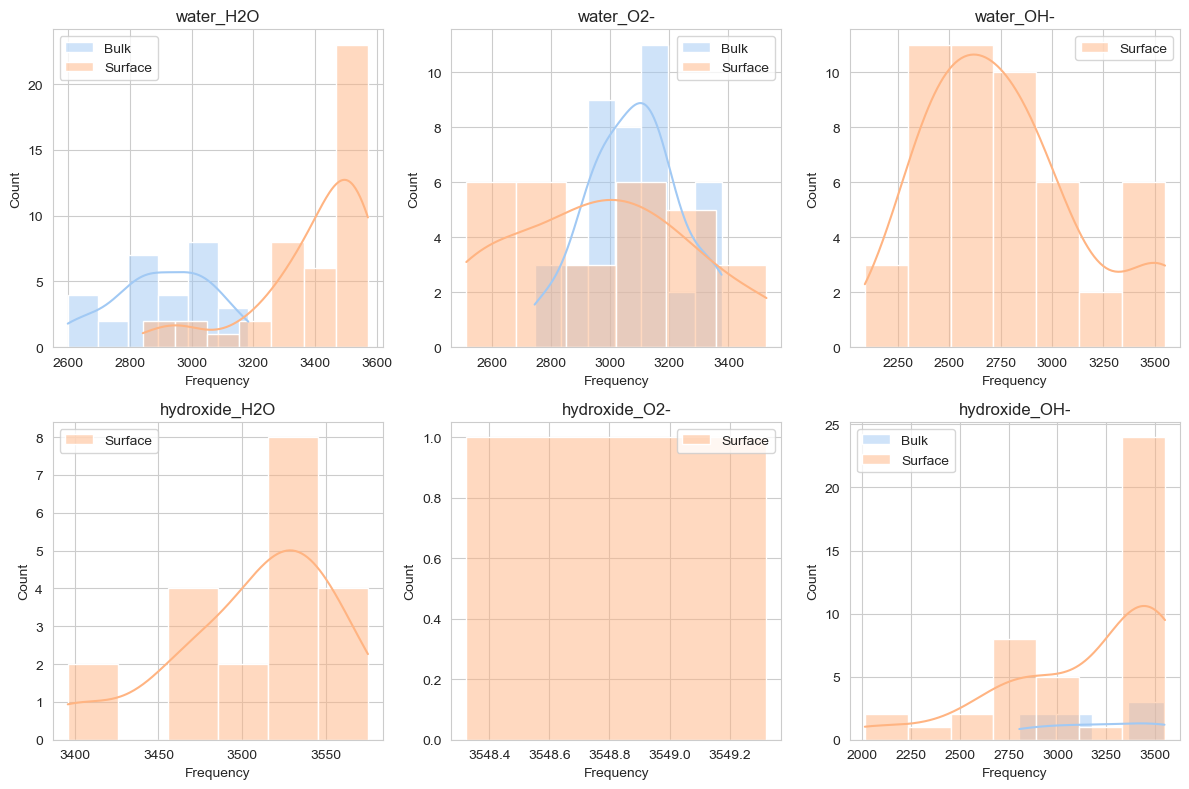

In [122]:
# Get the "pastel" color palette
palette = sns.color_palette("pastel")

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the combinations and arguments
for i, (combination, bulk_argument, surface_argument) in enumerate(zip(combinations, arguments_bulk, arguments_surface)):
    # Calculate the row and column indices for the subplot
    row = i // 3
    col = i % 3
    
    # Plot the frequency distribution on the corresponding subplot
    ax = axes[row, col]
    sns.histplot(data=bulk_argument, kde=True, color=palette[0], label='Bulk', ax=ax)
    sns.histplot(data=surface_argument, kde=True, color=palette[1], label='Surface', ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_title(f'{combination}')
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


There seems to be a large mismatch in the amount of bulk and surface data. We should therefor be careful when interpreting the statistics...But we can say that there is a difference between surface and bulk in the first category.

**To sum up this section:**
We now know that the specie and acceptor type (and their combination) influences the frequency, but we are still unsure about the difference between surface and bulk because of *class imbalance*. 

## Principal component analysis <a id='pca'></a>

In [123]:
# Make a copy of df_all so that we don't change anything in our original dataframe
df_PCA = df_all.copy()

# Iterate over the rows of df_all and create the "Group" column
df_PCA['Group'] = df_PCA.loc[:,'species'] + '_' + df_PCA.loc[:,'acceptor_type']

# Drop acceptor_type and species columns since they are now in the group column
df_PCA = df_PCA.drop(['acceptor_type', 'species'], axis=1)

df_PCA.head()

,environment,Frequency,EFddec,EFfc,rHO,rOO,tOHO,sOH,Group
0,bulk,2835.330710,NaN,0.110286,1.700949,2.700508,173.394783,0.829656,water_H2O
1,bulk,3183.645055,NaN,0.053310,1.803902,2.768058,164.461785,0.854042,water_O2-
2,bulk,3035.028611,NaN,0.056955,1.770575,2.750204,167.845087,0.844688,water_O2-
3,bulk,2897.650546,NaN,0.111810,1.711288,2.708017,173.473205,0.833939,water_H2O
4,bulk,3294.220653,NaN,0.001428,1.966437,2.945567,173.304077,0.893110,water_O2-


In [124]:
# Divide the data into surface and bulk data respectively.
bulk_PCA = df_PCA.loc[df_PCA['environment'] == 'bulk']
surface_PCA = df_PCA.loc[df_PCA['environment'] == 'surface']

# ...and drop the environment column
bulk_PCA = bulk_PCA.drop(['environment'], axis=1)
surface_PCA = surface_PCA.drop(['environment'], axis=1)

print(bulk_PCA.shape)
print(surface_PCA.shape)
surface_PCA

(77, 8)
(217, 8)


,Frequency,EFddec,EFfc,rHO,rOO,tOHO,sOH,Group
126,3577.868,0.000151,0.000402,3.000000,3.500000,100.000000,0.8974,NaN
127,3577.868,0.000152,0.000405,3.000000,3.500000,100.000000,0.8970,NaN
128,3511.409,0.015010,0.032563,3.000000,3.500000,100.000000,0.8292,water_H2O
129,2952.498,0.053806,0.102202,1.790404,2.653346,142.511457,0.7401,water_O2-
130,3514.452,0.039665,0.066010,3.000000,3.500000,100.000000,0.8793,hydroxide_OH-
...,...,...,...,...,...,...,...,...
338,2816.551,0.109617,0.163932,1.639930,2.539967,147.456023,0.7142,hydroxide_OH-
339,2528.199,0.110814,0.174560,1.648772,2.603764,155.716061,0.7341,hydroxide_OH-
340,3584.097,0.032979,0.060920,3.000000,3.500000,100.000000,0.9454,NaN
341,3047.550,0.041758,0.062331,1.917147,2.859469,156.956777,0.7842,water_OH-


In [125]:
# Clean data by removing rows and columns with NaN. 
# The bulk data has no values for EFddec, so that whole column will be removed
bulk_PCA = bulk_PCA.drop(['EFddec'], axis=1)
bulk_PCA = bulk_PCA.dropna()

surface_PCA = surface_PCA.dropna()

print(bulk_PCA.shape)
print(surface_PCA.shape)
surface_PCA

(70, 7)
(186, 8)


,Frequency,EFddec,EFfc,rHO,rOO,tOHO,sOH,Group
128,3511.409,0.015010,0.032563,3.000000,3.500000,100.000000,0.8292,water_H2O
129,2952.498,0.053806,0.102202,1.790404,2.653346,142.511457,0.7401,water_O2-
130,3514.452,0.039665,0.066010,3.000000,3.500000,100.000000,0.8793,hydroxide_OH-
132,2823.271,0.052979,0.097683,1.781552,2.758095,164.281236,0.7314,water_OH-
133,3524.150,0.037624,0.066687,3.000000,3.500000,100.000000,0.9084,hydroxide_OH-
...,...,...,...,...,...,...,...,...
336,2013.027,0.125282,0.206161,1.527088,2.489675,153.148573,0.7005,hydroxide_OH-
338,2816.551,0.109617,0.163932,1.639930,2.539967,147.456023,0.7142,hydroxide_OH-
339,2528.199,0.110814,0.174560,1.648772,2.603764,155.716061,0.7341,hydroxide_OH-
341,3047.550,0.041758,0.062331,1.917147,2.859469,156.956777,0.7842,water_OH-


### PCA: Bulk

In [126]:
from sklearn.preprocessing import StandardScaler

# Scale the data
bulk_features = bulk_PCA[['Frequency', 
                          'EFfc', 
                          'rHO', 
                          'rOO', 
                          'tOHO', 
                          'sOH']]

scaled_bulk = StandardScaler().fit_transform(bulk_features)

pd.DataFrame(scaled_bulk, columns = bulk_features.columns.values.tolist())

,Frequency,EFfc,rHO,rOO,tOHO,sOH
0,-0.991460,0.718758,-0.750331,-0.655473,0.651821,-0.401983
1,0.969692,-0.781065,0.346503,0.182926,-0.937429,0.515191
2,0.132921,-0.685105,-0.008553,-0.038669,-0.335513,0.163388
3,-0.640574,0.758878,-0.640188,-0.562276,0.665773,-0.240881
4,1.592277,-2.146776,2.078111,2.386066,0.635684,1.984550
...,...,...,...,...,...,...
65,-0.789396,1.035647,-0.654004,-0.636958,-0.012925,-0.628767
66,0.682293,0.475247,0.333241,0.361105,0.072160,0.378121
67,-0.000557,0.164119,0.030874,0.095538,0.244693,0.287557
68,0.847465,-0.624685,0.787343,0.493840,-1.889597,1.041227


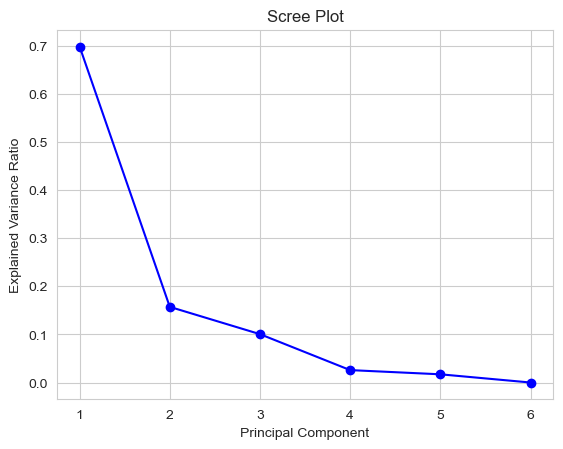

In [127]:
from sklearn.decomposition import PCA

# Perform PCA
pca_bulk = PCA()
bulk_pc = pca_bulk.fit_transform(scaled_bulk)

# Calculate the explained variance ratio
explained_variance_ratio = pca_bulk.explained_variance_ratio_

# Create the scree plot
num_components = len(explained_variance_ratio)
plt.plot(np.arange(1, num_components + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


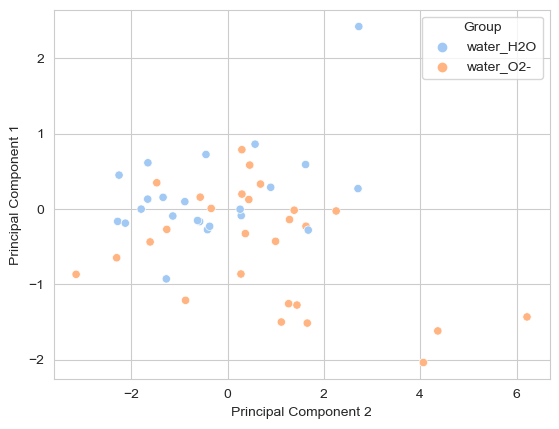

In [128]:
# Do it again but with only 2 components
pca_bulk2 = PCA(n_components=2)
bulk_pc2 = pca_bulk2.fit_transform(scaled_bulk)

# Save to a dataframe
pca2_df = pd.DataFrame(data = bulk_pc2, columns = ['pca1', 'pca2'])

# Make a 2D plot with the pca components as the axis
sns.scatterplot(pca2_df.pca1, pca2_df.pca2, hue = bulk_PCA.Group)
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.show()

### PCA: Surface

In [129]:
# Scale the data
surface_features = surface_PCA[['Frequency', 
                                'EFddec',
                                'EFfc', 
                                'rHO', 
                                'rOO', 
                                'tOHO', 
                                'sOH']]

scaled_surface = StandardScaler().fit_transform(surface_features)

pd.DataFrame(scaled_surface, columns = surface_features.columns.values.tolist())

,Frequency,EFddec,EFfc,rHO,rOO,tOHO,sOH
0,0.944846,-1.342132,-1.300162,1.487914,1.454210,-1.364270,0.643921
1,-0.400446,0.187395,0.380268,-0.791913,-0.926982,0.270352,-0.764851
2,0.952170,-0.370131,-0.493067,1.487914,1.454210,-1.364270,1.436059
3,-0.711494,0.154773,0.271235,-0.808596,-0.632378,1.107429,-0.902408
4,0.975513,-0.450590,-0.476734,1.487914,1.454210,-1.364270,1.896163
...,...,...,...,...,...,...,...
181,-2.661741,3.005328,2.888881,-1.288206,-1.387303,0.679364,-1.390972
182,-0.727668,2.387703,1.869852,-1.075523,-1.245857,0.460477,-1.174359
183,-1.421728,2.434914,2.126316,-1.058857,-1.066429,0.778087,-0.859718
184,-0.171657,-0.287581,-0.581844,-0.553028,-0.347265,0.825794,-0.067580


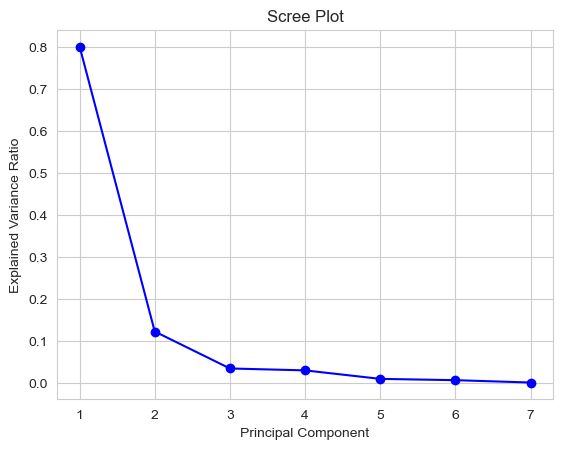

In [130]:
# Perform PCA
pca_surface = PCA()
surface_pc = pca_surface.fit_transform(scaled_surface)

# Calculate the explained variance ratio
explained_variance_ratio = pca_surface.explained_variance_ratio_

# Create the scree plot
num_components = len(explained_variance_ratio)
plt.plot(np.arange(1, num_components + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


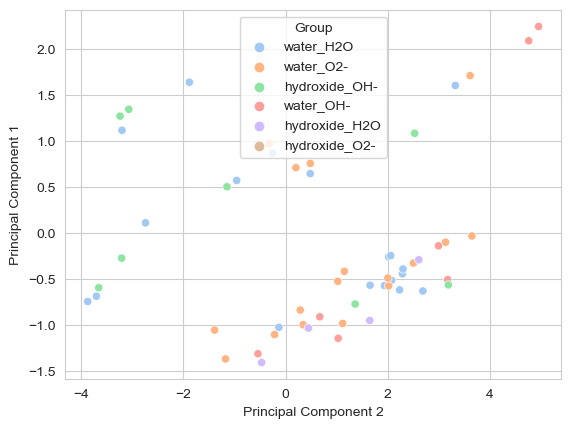

In [131]:
# Do it again but with only 2 components
pca_surface2 = PCA(n_components=2)
surface_pc2 = pca_surface2.fit_transform(scaled_surface)

# Save to a dataframe
pca2_df = pd.DataFrame(data = surface_pc2, columns = ['pca1', 'pca2'])

# Make a 2D plot with the pca components as the axis
sns.scatterplot(pca2_df.pca1, pca2_df.pca2, hue = surface_PCA.Group)
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.show()

### PCA: Surface vs bulk

In [132]:
# Clean data by removing rows and columns with NaN. 
# The bulk data has no values for EFddec, so that whole column will be removed
df_PCA = df_PCA.drop(['EFddec', 'Group'], axis=1).dropna()

df_PCA

,environment,Frequency,EFfc,rHO,rOO,tOHO,sOH
0,bulk,2835.330710,0.110286,1.700949,2.700508,173.394783,0.829656
1,bulk,3183.645055,0.053310,1.803902,2.768058,164.461785,0.854042
2,bulk,3035.028611,0.056955,1.770575,2.750204,167.845087,0.844688
3,bulk,2897.650546,0.111810,1.711288,2.708017,173.473205,0.833939
4,bulk,3294.220653,0.001428,1.966437,2.945567,173.304077,0.893110
...,...,...,...,...,...,...,...
338,surface,2816.551000,0.163932,1.639930,2.539967,147.456023,0.714200
339,surface,2528.199000,0.174560,1.648772,2.603764,155.716061,0.734100
340,surface,3584.097000,0.060920,3.000000,3.500000,100.000000,0.945400
341,surface,3047.550000,0.062331,1.917147,2.859469,156.956777,0.784200


In [133]:
# Scale the data
features = df_PCA[['Frequency', 
                   'EFfc', 
                   'rHO', 
                   'rOO', 
                   'tOHO', 
                   'sOH']]

scaled_features = StandardScaler().fit_transform(features)

pd.DataFrame(scaled_features, columns = features.columns.values.tolist())

,Frequency,EFfc,rHO,rOO,tOHO,sOH
0,-0.800153,0.610497,-0.870848,-0.731567,1.151673,0.334454
1,0.136370,-0.793398,-0.674776,-0.536060,0.839651,0.706458
2,-0.263219,-0.703575,-0.738247,-0.587734,0.957827,0.563768
3,-0.632592,0.648051,-0.851159,-0.709834,1.154413,0.399797
4,0.433678,-2.071757,-0.365231,-0.022309,1.148505,1.302428
...,...,...,...,...,...,...
282,-0.850647,1.932335,-0.987059,-1.196210,0.245652,-1.426780
283,-1.625948,2.194213,-0.970219,-1.011566,0.534169,-1.123212
284,1.213078,-0.605887,1.603174,1.582350,-1.411951,2.100093
285,-0.229553,-0.571117,-0.459102,-0.271495,0.577506,-0.358955


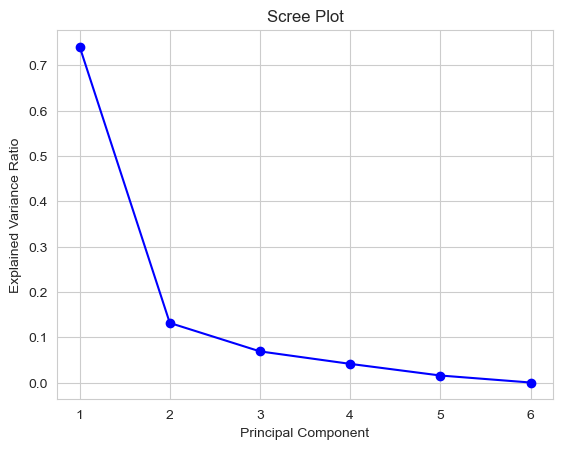

In [134]:
# Perform PCA
pca_all = PCA()
all_pc = pca_all.fit_transform(scaled_features)

# Calculate the explained variance ratio
explained_variance_ratio = pca_all.explained_variance_ratio_

# Create the scree plot
num_components = len(explained_variance_ratio)
plt.plot(np.arange(1, num_components + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


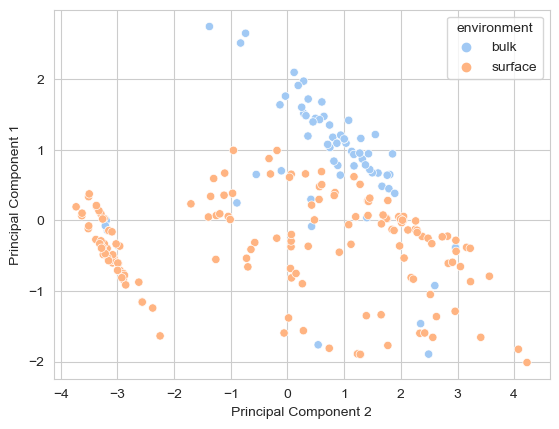

In [135]:
# Do it again but with only 2 components
pca_all2 = PCA(n_components=2)
all_pc2 = pca_all2.fit_transform(scaled_features)

# Save to a dataframe
pca2_df = pd.DataFrame(data = all_pc2, columns = ['pca1', 'pca2'])

# Make a 2D plot with the pca components as the axis
sns.scatterplot(pca2_df.pca1, pca2_df.pca2, hue = df_PCA.environment)
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.show()

## Model building through regression <a id='regression'></a>

In [136]:
from scipy.optimize import curve_fit

# Define the function to fit
def exponential_func(rHO, A, B, C):
    return A - B * np.exp(-rHO / C)

# Get the data for fitting
x_bulk = bulk_PCA['rHO']
y_bulk = bulk_PCA['Frequency']

x_surface = surface_PCA['rHO']
y_surface = surface_PCA['Frequency']

In [137]:
# Perform curve fitting for bulk environment
popt_bulk, pcov_bulk = curve_fit(exponential_func, x_bulk, y_bulk)
A_bulk, B_bulk, C_bulk = popt_bulk

model_equation_bulk = f"Frequency_bulk = {A_bulk:.2f} - {B_bulk:.2f} * exp(-rHO / {C_bulk:.2f})"

residuals_bulk = y_bulk - exponential_func(x_bulk, A_bulk, B_bulk, C_bulk)
ss_total_bulk = np.sum((y_bulk - np.mean(y_bulk)) ** 2)
ss_residual_bulk = np.sum(residuals_bulk ** 2)
r_squared_bulk = 1 - (ss_residual_bulk / ss_total_bulk)

# Perform curve fitting for surface environment
popt_surface, pcov_surface = curve_fit(exponential_func, x_surface, y_surface)
A_surface, B_surface, C_surface = popt_surface

model_equation_surface = f"Frequency_surface = {A_surface:.2f} - {B_surface:.2f} * exp(-rHO / {C_surface:.2f})"

residuals_surface = y_surface - exponential_func(x_surface, A_surface, B_surface, C_surface)
ss_total_surface = np.sum((y_surface - np.mean(y_surface)) ** 2)
ss_residual_surface = np.sum(residuals_surface ** 2)
r_squared_surface = 1 - (ss_residual_surface / ss_total_surface)

In [138]:
# Generate points for the regression lines
x_reg_bulk = np.linspace(min(x_bulk), max(x_bulk), 100)
y_reg_bulk = exponential_func(x_reg_bulk, A_bulk, B_bulk, C_bulk)

x_reg_surface = np.linspace(min(x_surface), max(x_surface), 100)
y_reg_surface = exponential_func(x_reg_surface, A_surface, B_surface, C_surface)

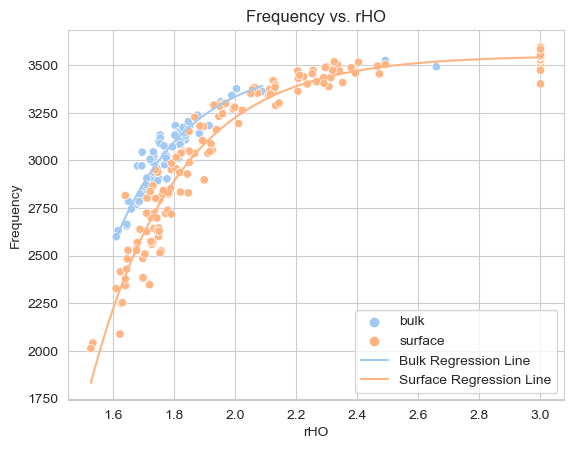

Bulk Environment:
Model Equation: Frequency_bulk = 3519.89 - 712125.70 * exp(-rHO / 0.24)
R-squared: 0.8819537653747804

Surface Environment:
Model Equation: Frequency_surface = 3551.15 - 369624.67 * exp(-rHO / 0.28)
R-squared: 0.9526954389587102


In [139]:
# Plot scatter plots and regression lines
sns.scatterplot(data=df_all, x='rHO', y='Frequency', hue='environment')
sns.lineplot(x=x_reg_bulk, y=y_reg_bulk, label='Bulk Regression Line')
sns.lineplot(x=x_reg_surface, y=y_reg_surface, label='Surface Regression Line')

plt.xlabel('rHO')
plt.ylabel('Frequency')
plt.title('Frequency vs. rHO')
plt.legend()
plt.show()

# Print the model equations and R-squared values
print("Bulk Environment:")
print("Model Equation:", model_equation_bulk)
print("R-squared:", r_squared_bulk)

print("\nSurface Environment:")
print("Model Equation:", model_equation_surface)
print("R-squared:", r_squared_surface)

## Reflections

- The combination of species and acceptor type is influencing the frequency. 
- We cannot convincingly say whether or not there is a difference between the surface and bulk data due to large differences in the data sets.
- We can fit a model of type Frequency = A - B * np.exp(-rHO / C) for both the bulk and surface data. The fit is, however, not great as indicated by the R-squared values, but a clear trend is visible in the plot. Both models are similar to the one found from the original paper.